In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter

Configuración de los parámetros

In [3]:
nx   = 500          # number of grid points in x-direction
nz   = nx           # number of grid points in z-direction
# Note: regular 2D grid, dz = dx
dx   = 1.           # grid point distance in x-direction
dz   = dx           # grid point distance in z-direction
c0   = 340.         # wave velocity in medium (m/s)
isx  = 250          # source location in grid in x-direction
isz  = isx          # source location in grid in z-direction
irx  = 300          # receiver location in grid in x-direction
irz  = irx          # receiver location in grid in z-direction
nt   = 702          # maximum number of time steps
dt   = 0.0010       # time step
f0   = 30. # dominant frequency of the source (Hz)
t0   = 2. / f0 # source time shift
op   = 3            # length of finite-difference operator (3 or 5)

Condiciones iniciales de presión


In [4]:
p    = np.zeros((nz, nx)) # p at time n (now)
pold = np.zeros((nz, nx)) # p at time n-1 (past)
pnew = np.zeros((nz, nx)) # p at time n+1 (present)
d2px = np.zeros((nz, nx)) # 2nd space derivative of p in x-direction
d2pz = np.zeros((nz, nx)) # 2nd space derivative of p in z-direction

Velocidad y grid inicial

In [5]:
c    = np.zeros((nz, nx))
c    = c + c0             # initialize wave velocity in model

x    = np.arange(nx)
x    = x * dx             # coordinate in x-direction
z    = np.arange(nz)
z    = z * dz             # coordinate in z-direction

Inicializo funcion fuente como un impulso modelado en base a una función gausianna

In [6]:
src  = np.zeros(nt + 1)
time = np.linspace(0 * dt, nt * dt, nt)
time2 = np.arange(0,nt*dt,dt)

# 1st derivative of a Gaussian
src  = -8. * (time - t0) * f0 * (np.exp(-1.0 * (4*f0) ** 2 * (time - t0) ** 2))

Calculas la ecuacion diferencial con el metodo de integracion finita. Usamos operador 3.

In [7]:
def draw_line(mat, x0, y0, x1, y1, inplace=False):
    if not (0 <= x0 < mat.shape[0] and 0 <= x1 < mat.shape[0] and
            0 <= y0 < mat.shape[1] and 0 <= y1 < mat.shape[1]):
        raise ValueError('Invalid coordinates.')
    if not inplace:
        mat = mat.copy()
    if (x0, y0) == (x1, y1):
        mat[x0, y0] = 2
        return mat if not inplace else None
    # Swap axes if Y slope is smaller than X slope
    transpose = abs(x1 - x0) < abs(y1 - y0)
    if transpose:
        mat = mat.T
        x0, y0, x1, y1 = y0, x0, y1, x1
    # Swap line direction to go left-to-right if necessary
    if x0 > x1:
        x0, y0, x1, y1 = x1, y1, x0, y0
    # Write line ends
    mat[x0, y0] = 0
    mat[x1, y1] = 0
    # Compute intermediate coordinates using line equation
    x = np.arange(x0 + 1, x1)
    y = np.round(((y1 - y0) / (x1 - x0)) * (x - x0) + y0).astype(x.dtype)
    # Write intermediate coordinates
    mat[x, y] = 0
    if not inplace:
        return mat if not transpose else mat.T

In [8]:
p_time = []
for it in range(nt):
    if op == 3: # use 3 point operator FD scheme
        for i in range(1, nx - 1):
            d2px[i, :] = (p[i - 1, :] - 2 * p[i, :] + p[i + 1, :]) / dx ** 2
            #d2px[350, 0:220] = 0
            #d2px[350, 260:499] = 0
        for j in range(1, nz - 1):
            d2pz[:, j] = (p[:, j - 1] - 2 * p[:, j] + p[:, j + 1]) / dz ** 2 
    #d2pz[120:180, 200] = 0
    #d2px[350, 0:220] = 0
    #d2px[350, 260:499] = 0
    
    #d2pz[200:300,400] = 0
    pnew = 2 * p - pold + (c ** 2) * (dt ** 2) * (d2pz + d2px)
    
    pnew[isz, isx] = pnew[isz, isx] + src[it] / (dx * dz) * (dt ** 2) 
    
    pold, p = p, pnew
    
    p = draw_line(p,20,20,300,350)
    
    p_time.append(p)

Para hacer un gráfico estatico

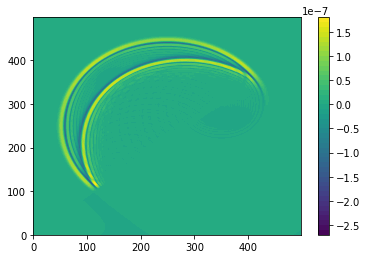

In [9]:
#x = np.arange(0,nx, dx)
#y = np.arange(0,nz, dz)
data = np.array(p_time)
plt.contourf(x, z, data[650,:,:], levels=50)
plt.colorbar()

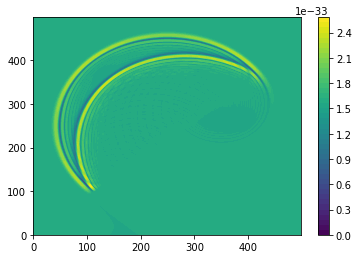

In [10]:
def animate(i):
    ax.clear()
    ax.contourf(x, z, data[i,:,:], levels=50)
    
fig, ax = plt.subplots(1,1)

fig.colorbar(ax.contourf(x, z, data[0,:,:], levels=50))
ani = animation.FuncAnimation(fig, animate, frames=680, interval=20)
ani.save('wave_3.gif',writer='pillow',fps=30)

Simulando pared en 300

In [48]:
nx1 =(1,300-1)
nx2 = (300,500-1)

nz1= (1,100)
nz2=(100,500-1)

p_time = []
for it in range(nt):
    if op == 3: # use 3 point operator FD scheme
        for i in range(1, nx - 1):
            d2px[i, :] = (p[i - 1, :] - 2 * p[i, :] + p[i + 1, :]) / dx ** 2 
        for j in range(1, nz - 1):
             
            if j > 300 and j < 305:    
                #d2pz[0:200, j] = (p[0:200, j - 1] - 2 * p[0:200, j] + p[0:200, j + 1]) / dz ** 2
                #d2pz[220:499, j] = (p[220:499, j - 1] - 2 * p[220:499, j] + p[220:499, j + 1]) / dz ** 2
                d2pz[200:220, j] = (p[200:220, j - 1] - 2 * p[200:220, j] + p[200:220, j + 1]) / dz ** 2
                d2pz[0:200, j] = 0
                d2pz[220:499, j] = 0
                
            else:
                d2pz[:, j] = (p[:, j - 1] - 2 * p[:, j] + p[:, j + 1]) / dz ** 2
    pnew = 2 * p - pold + (c ** 2) * (dt ** 2) * (d2pz + d2px)
    
    pnew[isz, isx] = pnew[isz, isx] + src[it] / (dx * dz) * (dt ** 2) 
    
    pold, p = p, pnew
    
    p_time.append(p)

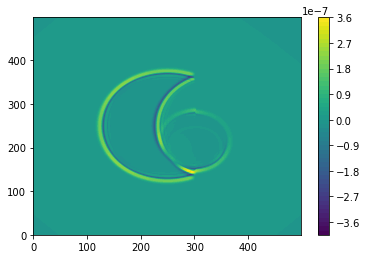

In [49]:
data = np.array(p_time)
plt.contourf(x, z, data[450,:,:], levels=50)
plt.colorbar()

In [57]:
test = np.zeros((5,5))

print(test)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [58]:
test[:,3][1:3] = np.ones(2)

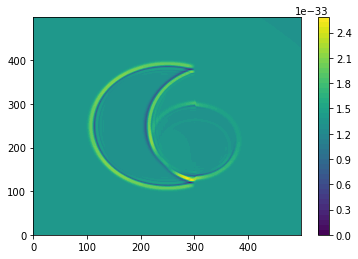

In [50]:
def animate(i):
    ax.clear()
    ax.contourf(x, z, data[i,:,:], levels=50)
    
fig, ax = plt.subplots(1,1)

fig.colorbar(ax.contourf(x, z, data[0,:,:], levels=50))
ani = animation.FuncAnimation(fig, animate, frames=500, interval=20)
ani.save('wave_2.gif',writer='pillow',fps=30)

In [16]:
test = [[2,3,4,5],[4,3,6,2],[6,7,4,3]]

In [25]:
(99%50) // 49 == 1


True